     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.9/97.9 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.0/377.0 kB 14.2 MB/s eta 0:00:00
weights_only=True failed: Weights only load failed. This file can still be loaded, to do so you have two options, do those steps only if you trust the source of the checkpoint. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL numpy._core.multiarray.scal

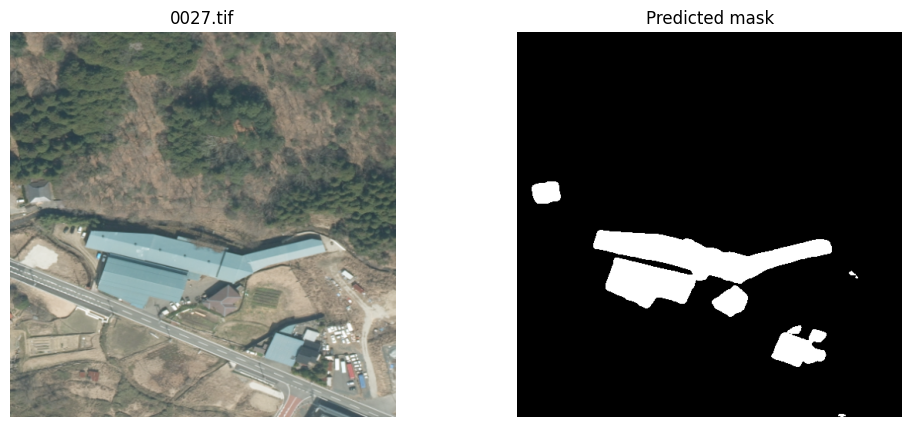

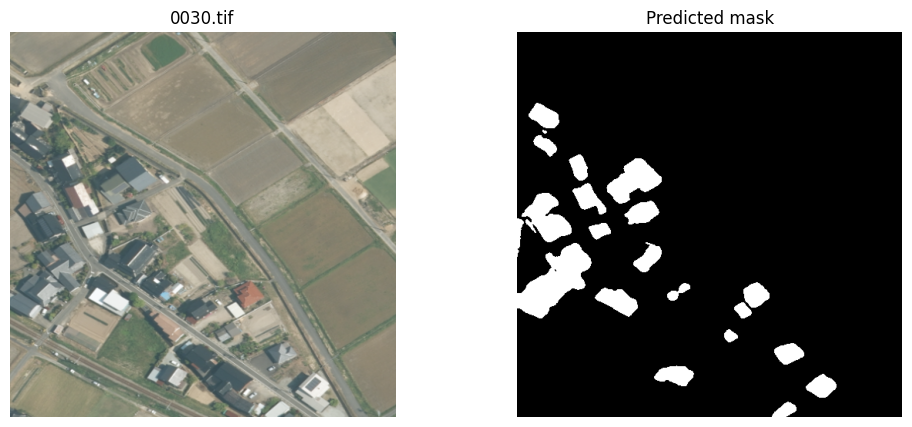

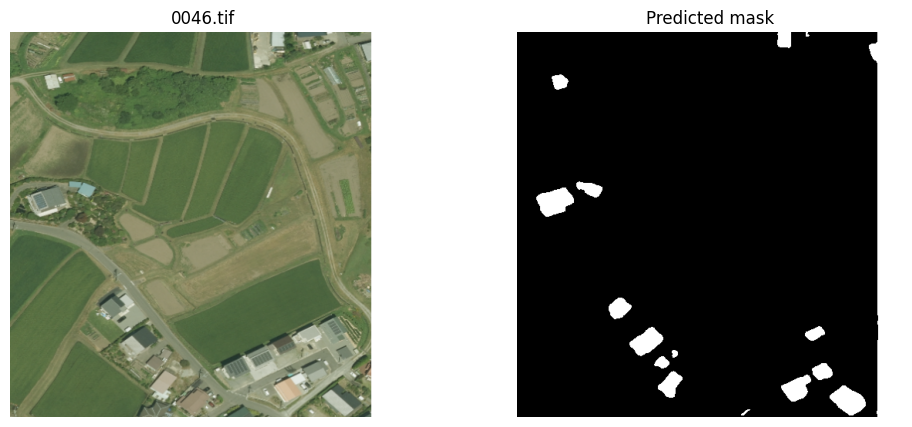

Done.


In [5]:
# -----------------------
# Install dependencies
# -----------------------
!pip install -q segmentation-models-pytorch==0.3.0 torchvision torch opencv-python matplotlib pillow tqdm


import io, zipfile, random, traceback
import urllib.request
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp

# -----------------------
# RAW URLs
# -----------------------
WEIGHTS_URL = "https://github.com/sequeiradiogo/Building-data-extraction/raw/main/models/unet_resnet34_epoch1_IoU0.7833.pth"
IMAGES_ZIP_URL = "https://github.com/sequeiradiogo/Building-data-extraction/raw/main/output/examples/test_images.zip"
MODEL_INPUT_SIZE = (512, 512)
THRESHOLD = 0.5

# -----------------------
# Safe in-memory checkpoint loader
# -----------------------
def safe_load_checkpoint_from_bytes(weights_bytes, map_location):
    bio = io.BytesIO(weights_bytes)
    try:
        ckpt = torch.load(bio, map_location=map_location, weights_only=True)
        print("Loaded checkpoint with weights_only=True")
        return ckpt
    except Exception as e:
        print("weights_only=True failed:", e)

    # fallback to trusted load
    try:
        bio.seek(0)
        ckpt = torch.load(bio, map_location=map_location, weights_only=False)
        print("Loaded checkpoint with weights_only=False (trusted load).")
        return ckpt
    except Exception as e_final:
        print("Trusted load also failed:", e_final)
        traceback.print_exc()
        raise RuntimeError("Could not load checkpoint: " + str(e_final))

# -----------------------
# Download model weights into memory
# -----------------------
print("Downloading model weights...")
with urllib.request.urlopen(WEIGHTS_URL) as response:
    weights_bytes = response.read()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights=None,
    in_channels=3,
    classes=1,
)

# -----------------------
# Load weights robustly
# -----------------------
ckpt = safe_load_checkpoint_from_bytes(weights_bytes, map_location=device)

if isinstance(ckpt, dict) and 'model_state_dict' in ckpt:
    model_state = ckpt['model_state_dict']
elif isinstance(ckpt, dict) and all(isinstance(v, torch.Tensor) for v in ckpt.values()):
    model_state = ckpt
else:
    try:
        model_state = ckpt.get('model_state_dict', ckpt)
    except Exception:
        model_state = ckpt

model.load_state_dict(model_state, strict=False)
model.to(device)
model.eval()
print("Model ready for inference.")

# -----------------------
# Download and unzip images in memory
# -----------------------
print("Downloading example images zip...")
with urllib.request.urlopen(IMAGES_ZIP_URL) as response:
    zip_bytes = io.BytesIO(response.read())

with zipfile.ZipFile(zip_bytes) as zf:
    image_files = [f for f in zf.namelist() if f.lower().endswith(('.tif'))]
    if len(image_files) < 3:
        raise ValueError(f"Need at least 3 images in the zip, found {len(image_files)}")
    sampled_files = random.sample(image_files, 3)
    images = {}
    for fname in sampled_files:
        with zf.open(fname) as f:
            file_bytes = np.frombuffer(f.read(), np.uint8)
            img_bgr = cv2.imdecode(file_bytes, cv2.IMREAD_COLOR)
            images[fname] = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

print("Selected images:", list(images.keys()))

# -----------------------
# Preprocess and inference
# -----------------------
def preprocess_image_for_model(orig_img_rgb, input_size):
    img = cv2.resize(orig_img_rgb, (input_size[1], input_size[0])).astype(np.float32)/255.0
    mean = np.array([0.485, 0.456, 0.406], dtype=np.float32)
    std  = np.array([0.229, 0.224, 0.225], dtype=np.float32)
    img = (img - mean)/std
    img = img.transpose(2,0,1)
    return torch.tensor(img).float().unsqueeze(0)

def show_prediction(orig, mask, title):
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.imshow(orig)
    plt.title(title)
    plt.axis("off")
    plt.subplot(1,2,2)
    plt.imshow(mask, cmap='gray')
    plt.title('Predicted mask')
    plt.axis('off')
    plt.show()

with torch.no_grad():
    for fname, img_rgb in images.items():
        h, w = img_rgb.shape[:2]
        inp = preprocess_image_for_model(img_rgb, MODEL_INPUT_SIZE).to(device)
        logits = model(inp)
        probs = torch.sigmoid(logits)[0,0].cpu().numpy()

        mask_small = (probs > THRESHOLD).astype(np.uint8) * 255
        mask = cv2.resize(mask_small, (w,h), interpolation=cv2.INTER_NEAREST)

        show_prediction(img_rgb, mask, title=fname)

print("Done.")